In [2]:
import cuspatial
import geopandas as gpd
import cudf
from numba import cuda
import numpy as np

# Get your data

In [11]:
!curl https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip -o zones.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1001k  100 1001k    0     0   920k      0  0:00:01  0:00:01 --:--:--  920k


In [12]:
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-01.csv -o taxi2015.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1893M  100 1893M    0     0  2970k      0  0:10:52  0:10:52 --:--:-- 2839k3  0:00:39 4100k


In [3]:
%%time
NYC_boroughs = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON')
NYC_boroughs.to_file('NYC_boroughs.shp')
NYC_gpu = cuspatial.read_polygon_shapefile('NYC_boroughs.shp')

CPU times: user 793 ms, sys: 253 ms, total: 1.05 s
Wall time: 7.6 s


# Let's check out the shape file

In [4]:
print(NYC_gpu)

(0     24
1     28
2     55
3     73
4    107
Name: f_pos, dtype: int32, 0         12
1        511
2        523
3        528
4        536
       ...  
102    70054
103    70300
104    75278
105    75291
106    75519
Name: r_pos, Length: 107, dtype: int32,                x          y
0     -73.896809  40.795808
1     -73.896785  40.796329
2     -73.897131  40.796798
3     -73.897883  40.797117
4     -73.898521  40.796936
...          ...        ...
75514 -73.907743  40.872846
75515 -73.907465  40.873547
75516 -73.907088  40.874326
75517 -73.906917  40.875056
75518 -73.906651  40.875753

[75519 rows x 2 columns])


In [5]:
t = NYC_gpu[2].iloc[511:522]
print(t)

             x          y
511 -73.898330  40.802413
512 -73.899387  40.801936
513 -73.899489  40.800901
514 -73.900037  40.800909
515 -73.899716  40.800799
516 -73.899787  40.799510
517 -73.900210  40.799264
518 -73.899025  40.799172
519 -73.898640  40.799101
520 -73.897985  40.799604
521 -73.896467  40.800790


## Working with Polygons
Let's look at and dive into the elements of the read shapefile using cuSpatial

In [6]:
print("Polygon Bounds:" , NYC_gpu[0]) # uppper bound of the rings that make up the polygon
print("Last Vertex:" , NYC_gpu[1]) # this is the position of the last vertex in each polygon

# You can get the lat/long by 
print("Latitude: " , NYC_gpu[2]['x']) # prints lat
print("Longitude: ", NYC_gpu[2]['y']) # prints long

NYC_gpu[2]['x'] = NYC_gpu[2]['x'].astype("float32")
NYC_gpu[2]['y'] = NYC_gpu[2]['y'].astype("float32")

Polygon Bounds: 0     24
1     28
2     55
3     73
4    107
Name: f_pos, dtype: int32
Last Vertex: 0         12
1        511
2        523
3        528
4        536
       ...  
102    70054
103    70300
104    75278
105    75291
106    75519
Name: r_pos, Length: 107, dtype: int32
Latitude:  0       -73.896809
1       -73.896785
2       -73.897131
3       -73.897883
4       -73.898521
           ...    
75514   -73.907743
75515   -73.907465
75516   -73.907088
75517   -73.906917
75518   -73.906651
Name: x, Length: 75519, dtype: float64
Longitude:  0        40.795808
1        40.796329
2        40.796798
3        40.797117
4        40.796936
           ...    
75514    40.872846
75515    40.873547
75516    40.874326
75517    40.875056
75518    40.875753
Name: y, Length: 75519, dtype: float64


In [7]:
NYC_gpu[1].head(25) #this set of rings are NYC_gpu[1][0] (the first polygon). This data is packed.  

0       12
1      511
2      523
3      528
4      536
5      561
6      581
7     1968
8     2065
9     2255
10    2260
11    2389
12    2496
13    2633
14    2638
15    2643
16    2649
17    2657
18    2664
19    2680
20    2685
21    2690
22    2714
23    8509
24    8556
Name: r_pos, dtype: int32

## Taxi Data
Let's import the taxi data.  Newer years have pickup/drop off location ids that you would have to cross correlate.  Older years, like 2015 give you a lon/lat values.  We'll be using those ideas

In [8]:
taxi2015 = cudf.read_csv("taxi2015.csv")
print(taxi2015.dtypes)

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object


In [9]:
taxi2015.count()

VendorID                 12748986
tpep_pickup_datetime     12748986
tpep_dropoff_datetime    12748986
passenger_count          12748986
trip_distance            12748986
pickup_longitude         12748986
pickup_latitude          12748986
RateCodeID               12748986
store_and_fwd_flag       12748986
dropoff_longitude        12748986
dropoff_latitude         12748986
payment_type             12748986
fare_amount              12748986
extra                    12748986
mta_tax                  12748986
tip_amount               12748986
tolls_amount             12748986
improvement_surcharge    12748983
total_amount             12748986
dtype: int64

As you can see, the columns that we're interested in for our spatial analysis are `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude`.  However, they are float64 and should to be typed as float32 for best performance.

In [10]:
taxi2015['pickup_longitude'] = taxi2015['pickup_longitude'].astype('float32')
taxi2015['pickup_latitude'] = taxi2015['pickup_latitude'].astype('float32')

taxi2015['dropoff_longitude'] = taxi2015['dropoff_longitude'].astype('float32')
taxi2015['dropoff_latitude'] = taxi2015['dropoff_latitude'].astype('float32')

In [11]:
%%time
pickups = cuspatial.point_in_polygon_bitmap(taxi2015['pickup_longitude'] , taxi2015['pickup_latitude'], NYC_gpu[0], NYC_gpu[1], NYC_gpu[2]['x'], NYC_gpu[2]['y'])
dropoffs = cuspatial.point_in_polygon_bitmap(taxi2015['dropoff_longitude'] , taxi2015['dropoff_latitude'], NYC_gpu[0], NYC_gpu[1], NYC_gpu[2]['x'], NYC_gpu[2]['y'])

CPU times: user 27.4 s, sys: 20.5 ms, total: 27.4 s
Wall time: 27.4 s


In [53]:
pickups.head()

,in_polygon_24,in_polygon_28,in_polygon_55,in_polygon_73,in_polygon_107,polygon
31,0,0,0,0,0,0
61,0,0,0,0,0,0
66,0,0,0,0,0,0
157,0,0,0,0,0,0
159,0,0,0,0,0,0


In [54]:
dropoffs.head()

,in_polygon_24,in_polygon_28,in_polygon_55,in_polygon_73,in_polygon_107,polygon
31,0,0,0,0,0,0
61,0,0,0,0,0,0
66,0,0,0,0,0,0
119,0,0,0,0,0,0
157,0,0,0,0,0,0


That's over 25 million points into 75.5K points in 5 polygons.  Graph theretically, if you wanted to do a pairwise metric to compute this without cuSpatial, you're starting to approach "lifetime of the universe" computation times.  Not apples to apples, but that's what just happened.  Also should explain why we're **NOT going to do full CPU times**.  We will take a subset, to give you a taste though

In [35]:
t = NYC_gpu[2].iloc[511:522]
print(t)
NYC_shape = list(zip(t['x'].tolist(), t['y'].tolist()))
print(NYC_shape)

             x          y
511 -73.898331  40.802414
512 -73.899391  40.801937
513 -73.899490  40.800900
514 -73.900040  40.800907
515 -73.899719  40.800800
516 -73.899788  40.799511
517 -73.900208  40.799263
518 -73.899025  40.799171
519 -73.898643  40.799103
520 -73.897987  40.799603
521 -73.896469  40.800789
[(-73.89833068847656, 40.80241394042969), (-73.8993911743164, 40.801937103271484), (-73.89949035644531, 40.800899505615234), (-73.90003967285156, 40.800907135009766), (-73.89971923828125, 40.80080032348633), (-73.89978790283203, 40.79951095581055), (-73.90020751953125, 40.79926300048828), (-73.8990249633789, 40.799171447753906), (-73.89864349365234, 40.799102783203125), (-73.89798736572266, 40.79960250854492), (-73.89646911621094, 40.80078887939453)]


In [13]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [51]:
%time
outcome = []
outcome_yes = 0
outcome_no = 0
points = list(zip(taxi2015['pickup_latitude'].tolist(), taxi2015['pickup_longitude'].tolist()))
polygon = Polygon(NYC_shape)
#for i in range(0, 100): # if you have the time, change this to `for i in range(0, len(points)):`
for i in range(0, len(points)):
    point = Point(points[i])
    if(point.contains(polygon)):
        outcome_yes += 1
    else:
        outcome_no += 1
    #outcome.append(point.contains(polygon)) #to keep track of the ride that would start in that polygon
print("yes: ", outcome_yes, "no: " , outcome_no)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
yes:  0 no:  12748986


Disappointing, right?  It says 5 microseconds, but you waited for a few minutes before you got an output...and none of the points were in that polygon

Let's make all the booleans into integers (dirty way)

In [43]:
pickups = pickups*1
dropoffs = dropoffs*1

In [44]:
%%time
cols = ["in_polygon_24", "in_polygon_28", "in_polygon_55", "in_polygon_73", "in_polygon_107"] 
groups = pickups.groupby(cols, method='cudf')
# Define a function to apply to each group
def mult_add(in_polygon_24, in_polygon_28, in_polygon_55, in_polygon_73, in_polygon_107, polygon):
    for i in range(cuda.threadIdx.x, len(in_polygon_24), cuda.blockDim.x):
        if(in_polygon_24[i] == 1):
            polygon[i] = 24
        elif(in_polygon_28[i] == 1):
            polygon[i] = 28
        elif(in_polygon_55[i] == 1):
            polygon[i] = 55
        elif(in_polygon_73[i] == 1):
            polygon[i] = 73
        elif(in_polygon_107[i] == 1):
            polygon[i] = 107
        else:
            polygon[i] = 0

pickups = groups.apply_grouped(mult_add,
                              incols=["in_polygon_24", "in_polygon_28", "in_polygon_55", "in_polygon_73", "in_polygon_107"],
                              outcols={'polygon': np.int32},
                              # threads per block
                              tpb=8)
groups = dropoffs.groupby(cols, method='cudf')
dropoffs = groups.apply_grouped(mult_add,
                              incols=["in_polygon_24", "in_polygon_28", "in_polygon_55", "in_polygon_73", "in_polygon_107"],
                              outcols={'polygon': np.int32},
                              # threads per block
                              tpb=8)
print(pickups.head())
print(dropoffs.head())

     in_polygon_24  in_polygon_28  in_polygon_55  in_polygon_73  \
31               0              0              0              0   
61               0              0              0              0   
66               0              0              0              0   
157              0              0              0              0   
159              0              0              0              0   

     in_polygon_107  polygon  
31                0        0  
61                0        0  
66                0        0  
157               0        0  
159               0        0  
     in_polygon_24  in_polygon_28  in_polygon_55  in_polygon_73  \
31               0              0              0              0   
61               0              0              0              0   
66               0              0              0              0   
119              0              0              0              0   
157              0              0              0              0   

     in_

## Add the outputs to your taxi dataframe

In [46]:
taxi2015['pu_brgh'] = pickups['polygon']
taxi2015['do_brgh'] = dropoffs['polygon']

In [47]:
taxi2015.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pu_brgh,do_brgh
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,107,107
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,107,107
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,107,107
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,107,107
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,107,107


In [98]:
taxi_cor = taxi2015.query('pu_brgh != 0')
taxi_cor = taxi_cor.query('do_brgh != 0')

In [88]:
taxi_cor['do_brgh'].value_counts()

107    11122767
55       640551
73       600195
24        68248
28         2428
Name: do_brgh, dtype: int32

In [89]:
taxi_cor.count()

VendorID                 12434189
tpep_pickup_datetime     12434189
tpep_dropoff_datetime    12434189
passenger_count          12434189
trip_distance            12434189
pickup_longitude         12434189
pickup_latitude          12434189
RateCodeID               12434189
store_and_fwd_flag       12434189
dropoff_longitude        12434189
dropoff_latitude         12434189
payment_type             12434189
fare_amount              12434189
extra                    12434189
mta_tax                  12434189
tip_amount               12434189
tolls_amount             12434189
improvement_surcharge    12434189
total_amount             12434189
pu_brgh                  12434189
do_brgh                  12434189
dtype: int64

In [101]:
taxi_cor['interb']= (taxi_cor[[]].assign(interb=taxi_cor.pu_brgh != taxi_cor.do_brgh))*1

In [102]:
print(taxi_cor['interb'].head())

0    0
1    0
2    0
3    0
4    0
Name: interb, dtype: int8


In [103]:
taxi_intra = taxi_cor.query('interb== 0')
taxi_inter = taxi_cor.query('interb!= 0')

# Visualization with Datashader
(You may remember me from other noteboks like...)  

We're going to do 8 visualizations
1) original data pickups
2) original data dropoffs
3) cuSpatial cleaned pickups
4) cuSpatial cleaned dropoffs
5) cleaned intraborough pickups
6) cleaned intraborough dropoffs
7) cleaned interborough pickups
8) cleaned interborough dropoffs

In [111]:
import cuxfilter
from bokeh import palettes
from cuxfilter.layouts import double_feature

In [104]:
from pyproj import Proj, Transformer
map_cux= cudf.DataFrame()
def makeXfilter(x, y):
    temp= cudf.DataFrame()
    transform_4326_to_3857 = Transformer.from_crs('epsg:4326', 'epsg:3857')
    temp['x'], temp['y'] = transform_4326_to_3857.transform(
                                                x.to_array(), y.to_array()
                                            )
    # Filter over Manhattan
    temp = temp[
        (temp.x > -8239910.23) & (temp.x < -8229529.24) & (temp.y > 4968481.34) & (temp.y < 4983152.92)
    ]
    print(temp.head())
    return temp.x, temp.y

map_cux['pu_x'], map_cux['pu_y'] = makeXfilter(taxi2015['pickup_latitude'], taxi2015['pickup_longitude'])
map_cux['do_x'], map_cux['do_y'] = makeXfilter(taxi2015['dropoff_latitude'],taxi2015['dropoff_longitude'])
map_cux['pu_x_cor'], map_cux['pu_y_cor'] = makeXfilter(taxi_cor['pickup_latitude'], taxi_cor['pickup_longitude'])
map_cux['do_x_cor'], map_cux['do_y_cor'] = makeXfilter(taxi_cor['dropoff_latitude'],taxi_cor['dropoff_longitude'])

map_cux['pu_x_intra'], map_cux['pu_y_intra'] = makeXfilter(taxi_intra['pickup_latitude'], taxi_intra['pickup_longitude'])
map_cux['do_x_intra'], map_cux['do_y_intra'] = makeXfilter(taxi_intra['dropoff_latitude'],taxi_intra['dropoff_longitude'])
map_cux['pu_x_inter'], map_cux['pu_y_inter'] = makeXfilter(taxi_inter['pickup_latitude'], taxi_inter['pickup_longitude'])
map_cux['do_x_inter'], map_cux['do_y_inter'] = makeXfilter(taxi_inter['dropoff_latitude'],taxi_inter['dropoff_longitude'])
print(map_cux.head())
cux = cuxfilter.DataFrame.from_dataframe(map_cux)

              x             y
0 -8.236963e+06  4.975553e+06
1 -8.237826e+06  4.971752e+06
3 -8.238654e+06  4.970221e+06
4 -8.234434e+06  4.977363e+06
6 -8.235781e+06  4.972012e+06
              x             y
0 -8.234835e+06  4.975627e+06
1 -8.237021e+06  4.976875e+06
3 -8.238124e+06  4.971127e+06
4 -8.238108e+06  4.974457e+06
5 -8.236193e+06  4.976740e+06
              x             y
0 -8.236963e+06  4.975553e+06
1 -8.237826e+06  4.971752e+06
3 -8.238654e+06  4.970221e+06
4 -8.234434e+06  4.977363e+06
6 -8.235781e+06  4.972012e+06
              x             y
0 -8.234835e+06  4.975627e+06
1 -8.237021e+06  4.976875e+06
3 -8.238124e+06  4.971127e+06
4 -8.238108e+06  4.974457e+06
5 -8.236193e+06  4.976740e+06
              x             y
0 -8.236963e+06  4.975553e+06
1 -8.237826e+06  4.971752e+06
3 -8.238654e+06  4.970221e+06
4 -8.234434e+06  4.977363e+06
5 -8.235781e+06  4.972012e+06
              x             y
0 -8.234835e+06  4.975627e+06
1 -8.237021e+06  4.976875e+06
3 -8.23812

In [110]:
from bokeh.tile_providers import get_provider as gp
tile_provider = gp('CARTODBPOSITRON')

In [112]:
chart1 = cuxfilter.charts.scatter_geo(x='pu_x',
                                         y='pu_y',
                                         aggregate_fn='count',
                                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))
chart2 = cuxfilter.charts.scatter_geo(x='do_x',
                                         y='do_y',
                                         aggregate_fn='count',
                                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))
chart3 = cuxfilter.charts.scatter_geo(x='pu_x_cor',
                                         y='pu_y_cor',
                                         aggregate_fn='count',
                                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))
chart4 = cuxfilter.charts.scatter_geo(x='do_x_cor',
                                         y='do_y_cor',
                                         aggregate_fn='count',
                                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))
chart5 = cuxfilter.charts.scatter_geo(x='pu_x_intra',
                                         y='pu_y_intra',
                                         aggregate_fn='count',
                                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))
chart6 = cuxfilter.charts.scatter_geo(x='do_x_intra',
                                         y='do_y_intra',
                                         aggregate_fn='count',
                                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))
chart7 = cuxfilter.charts.scatter_geo(x='pu_x_inter',
                                         y='pu_y_inter',
                                         aggregate_fn='count',
                                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))
chart8 = cuxfilter.charts.scatter_geo(x='do_x_inter',
                                         y='do_y_inter',
                                         aggregate_fn='count',
                                         tile_provider=tile_provider, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92))
#chart3 = cuxfilter.charts.bar('passenger_count', data_points=9)

In [113]:
d = cux.dashboard([chart1, chart2, chart3, chart4, chart5, chart6, chart7, chart8], layout=cuxfilter.layouts.three_by_three, theme=cuxfilter.themes.dark, title= 'NYC TAXI DATASET')

In [114]:
d

#### cuxfilter DashBoard
    
    [title] Markdown(str)
    [chart1] Column(sizing_mode='scale_both', width=533)
    [0] Bokeh(Figure)
    [chart2] Column(sizing_mode='scale_both', width=533)
    [0] Bokeh(Figure)
    [chart3] Column(sizing_mode='scale_both', width=533)
    [0] Bokeh(Figure)
    [chart4] Column(sizing_mode='scale_both', width=533)
    [0] Bokeh(Figure)
    [chart5] Column(sizing_mode='scale_both', width=533)
    [0] Bokeh(Figure)
    [chart6] Column(sizing_mode='scale_both', width=533)
    [0] Bokeh(Figure)
    [chart7] Column(sizing_mode='scale_both', width=533)
    [0] Bokeh(Figure)
    [chart8] Column(sizing_mode='scale_both', width=533)
    [0] Bokeh(Figure)
    [chart9] Markdown(str)
    [widgets] Column
    [0] Column(css_classes=['non-handle-temp'], sizing_mode='scale_both')
        [0] FloatSlider(bar_color='#8735fb', end=11589162, name='Data Points selected', sizing_mode='scale_both', start=0, value=11589162, width=280)

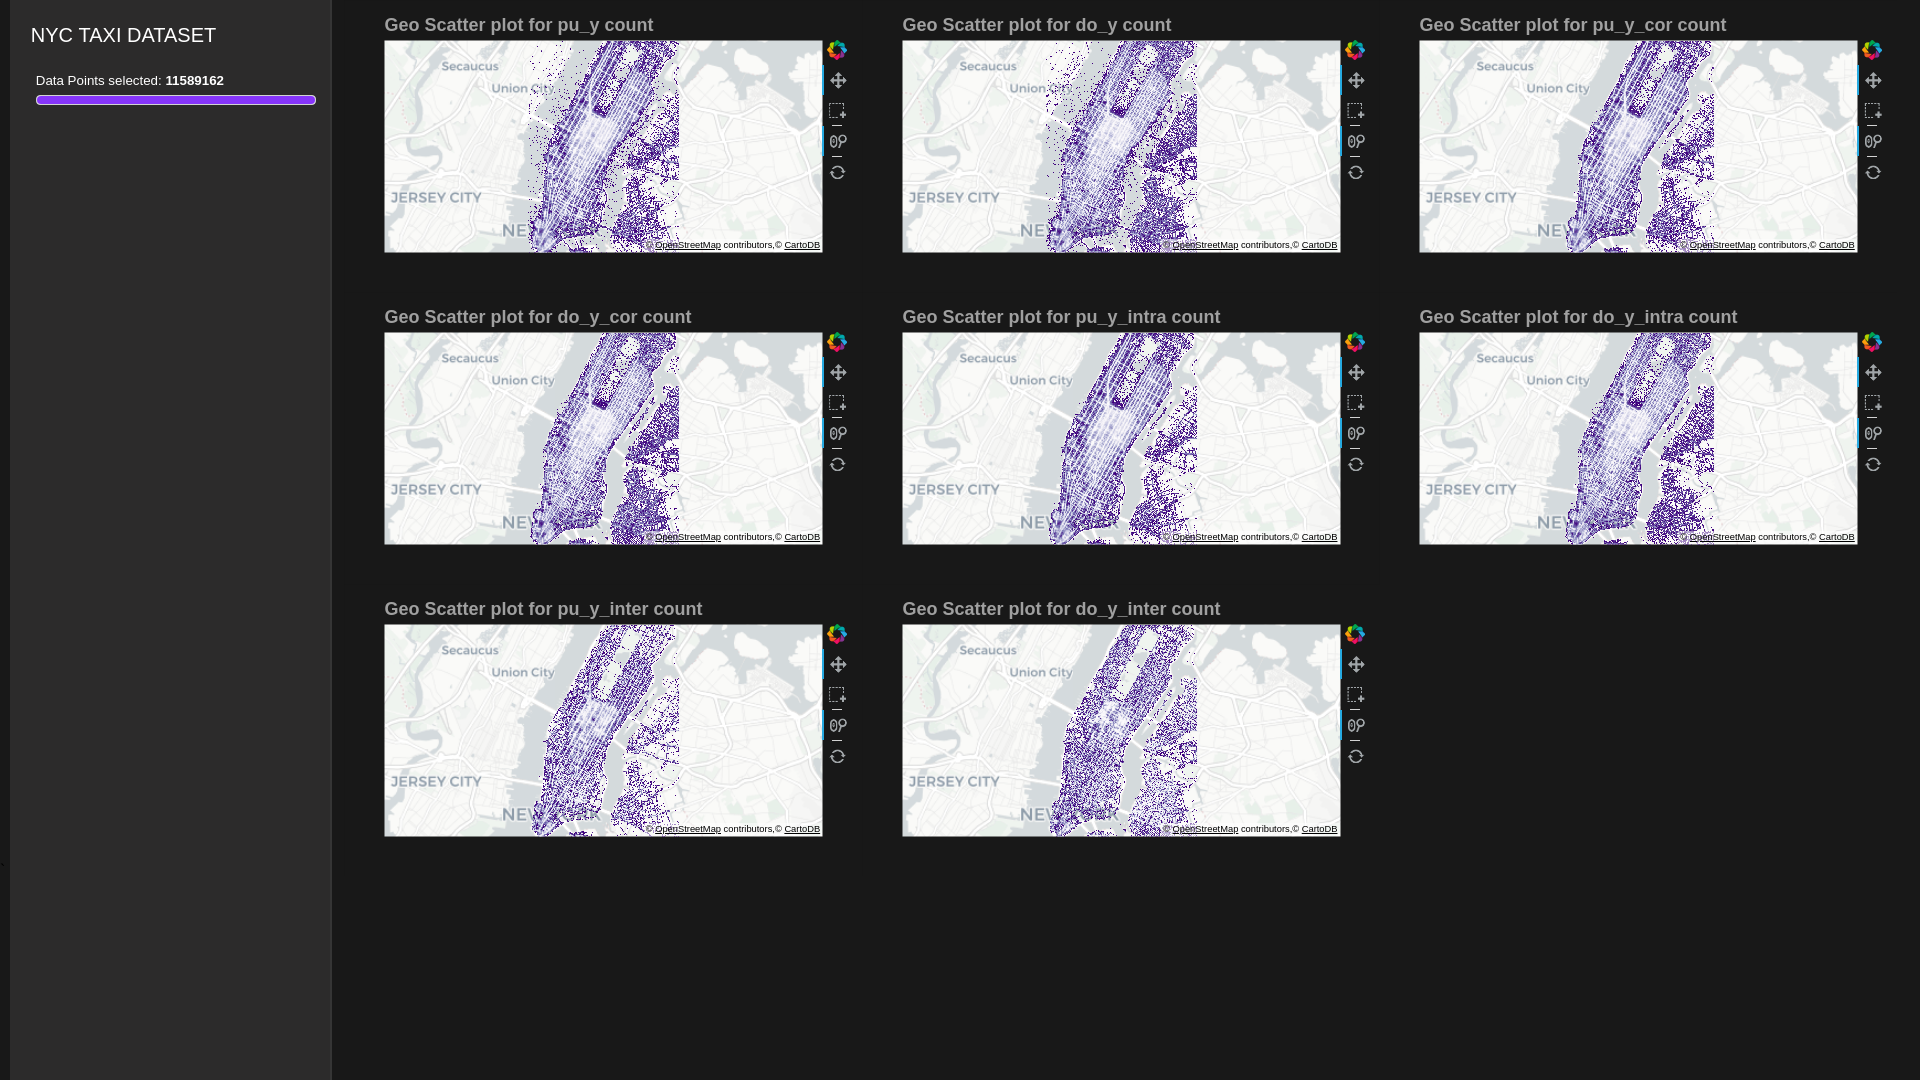

In [115]:
await d.preview()

In [116]:
d.show('<add your notebook server's url>:<add your notebook server's port number>)

Dashboard running at http://-------/proxy/44683/
